In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
uav_path = './Purdue/allnew/Unloaded/*.wav'
loaded_path = './Purdue/allnew/Loaded/*.wav'
none_path = './Purdue/allnew/Background/*.wav'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [3]:
CHUNK_SIZE = 8192
SR = 44100
N_MFCC = 16

In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw = load(loaded_files)
none_raw = load(none_files)

(54636926,)
(62515322,)
(86495188,)


# Data Processing

In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=44100, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_loaded, y_loaded = mfcc4(loaded_raw, 2)
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
mfcc_none, y_none = mfcc4(none_raw, 0)

print(mfcc_uav.shape, y_uav.shape)
print(mfcc_loaded.shape, y_loaded.shape)
print(mfcc_none.shape, y_none.shape)

(62515322,)
small end: (16, 13)
small end: (16, 5)
(54636926,)
small end: (16, 9)
small end: (16, 1)
(86495188,)
small end: (16, 16)
small end: (16, 8)
(13338, 16, 16) (13338,)
(15261, 16, 16) (15261,)
(21115, 16, 16) (21115,)


In [8]:
X = np.concatenate((mfcc_loaded, mfcc_uav, mfcc_none), axis=0)
y = np.hstack((y_loaded, y_uav, y_none))
print(X.shape, y.shape)

(49714, 16, 16) (49714,)


In [9]:
n_labels = y.shape[0]
n_unique_labels = 3
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(49714, 3)


In [10]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape, X_test.shape)
print(X_val.shape, y_val.shape)
print(y_train.shape, y_test.shape)

(31816, 16, 16) (9943, 16, 16)
(7955, 16, 16) (7955, 3)
(31816, 3) (9943, 3)


In [13]:
np.save('./X_train_chunk_3d', X_train)
np.save('./X_test_chunk_3d', X_test)
np.save('./X_val_chunk_3d', X_val)
np.save('./y_val_chunk_3d', y_val)
np.save('./y_train_chunk_3d', y_train)
np.save('./y_test_chunk_3d', y_test)

In [14]:
X_train = np.load('./X_train_chunk_3d.npy')
X_test = np.load('./X_test_chunk_3d.npy')
X_val = np.load('./X_val_chunk_3d.npy')
y_val = np.load('./y_val_chunk_3d.npy')
y_train = np.load('./y_train_chunk_3d.npy')
y_test = np.load('./y_test_chunk_3d.npy')

# Experiment 3 - two convolutional layer /w no dropout

##Experiment 3-2
- learning rate 0.005
- pooling stride 1x1
- #filter 1
- best result among every other settings
- cost kept fluctuated during training. (0.8 -> 1.3) -- why is that?

In [15]:
tf.reset_default_graph()

In [16]:
n_mfcc = 16
n_frame = 16
n_classes = 3
n_channels = 1

learning_rate = 0.0002  # 0.005
training_epochs = 100

# Layer 1 

In [17]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)

conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

In [18]:
dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Y_pred = tf.contrib.layers.fully_connected(logits,n_classes,activation_fn = None)

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val2 = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [21]:
model_path = './cnnmodel'
saver = tf.train.Saver()

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools as it

In [23]:
###########################
batch_size = 32
cost_history = np.empty(shape=[1], dtype=float)

for epoch in range(training_epochs):#training epoch 500 / batch_size 128 --> acc 90%
    avg_cost = 0
    val_avg_cost =0
    total_batch = int(y_train.shape[0] / batch_size)
    for i in range(0, y_train.shape[0], batch_size):
        feed_dict={X:X_train2[i:i+batch_size,:,:,:], Y:y_train[i:i+batch_size,:]}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        cost_history = np.append(cost_history,cost)
        avg_cost += c/total_batch 
    
    y_pred = sess.run(logits, feed_dict={X:X_val2})
    y_pred = sess.run(tf.argmax(y_pred,1))
    y_true = y_val
        
    y_true = sess.run(tf.argmax(y_true,1))
    print(len(y_pred),end=' ')
    print('Epoch:', '%04d' % (epoch+1), 'cost = ', '{:.9f}'.format(avg_cost), 'val = ','%f' %(accuracy_score(y_true, y_pred)) )
saver.save(sess, model_path)

7955 Epoch: 0001 cost =  0.918375340 val =  0.692395
7955 Epoch: 0002 cost =  0.617529218 val =  0.797109
7955 Epoch: 0003 cost =  0.515693031 val =  0.842112
7955 Epoch: 0004 cost =  0.464094469 val =  0.842740
7955 Epoch: 0005 cost =  0.419225469 val =  0.859459
7955 Epoch: 0006 cost =  0.389443128 val =  0.877184
7955 Epoch: 0007 cost =  0.368660570 val =  0.880955
7955 Epoch: 0008 cost =  0.352114612 val =  0.883470
7955 Epoch: 0009 cost =  0.337683027 val =  0.888498
7955 Epoch: 0010 cost =  0.324953577 val =  0.889001
7955 Epoch: 0011 cost =  0.308563175 val =  0.892143
7955 Epoch: 0012 cost =  0.294910724 val =  0.891138
7955 Epoch: 0013 cost =  0.281213767 val =  0.890886
7955 Epoch: 0014 cost =  0.268275582 val =  0.890383
7955 Epoch: 0015 cost =  0.257255272 val =  0.894155
7955 Epoch: 0016 cost =  0.245656570 val =  0.891640
7955 Epoch: 0017 cost =  0.237406235 val =  0.893275
7955 Epoch: 0018 cost =  0.227826158 val =  0.892018
7955 Epoch: 0019 cost =  0.221236375 val =  0.

'./cnnmodel'

In [24]:
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test2})
y_true = sess.run(tf.argmax(y_test,1))

F-Score: 0.902
Accuracy:  0.9016393442622951
             precision    recall  f1-score   support

          0       0.91      0.96      0.93      4191
          1       0.92      0.83      0.87      2652
          2       0.88      0.89      0.89      3100

avg / total       0.90      0.90      0.90      9943

[[4013   55  123]
 [ 208 2191  253]
 [ 208  131 2761]]


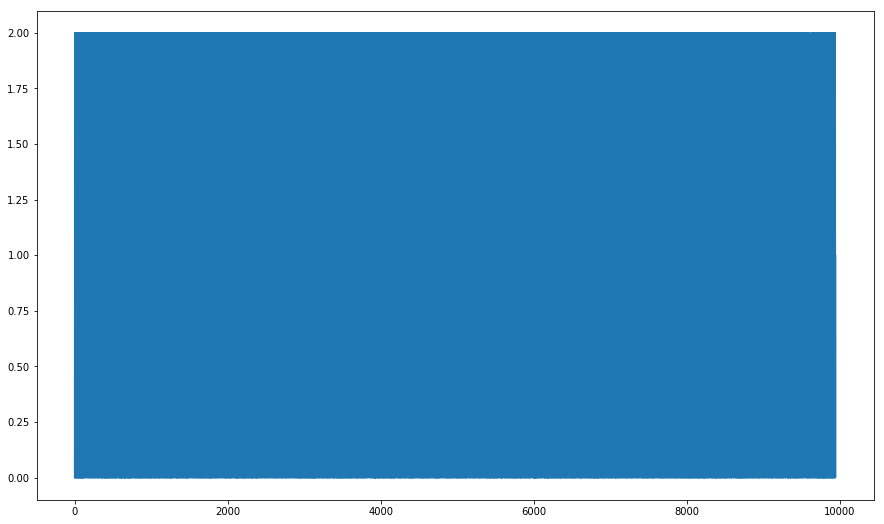

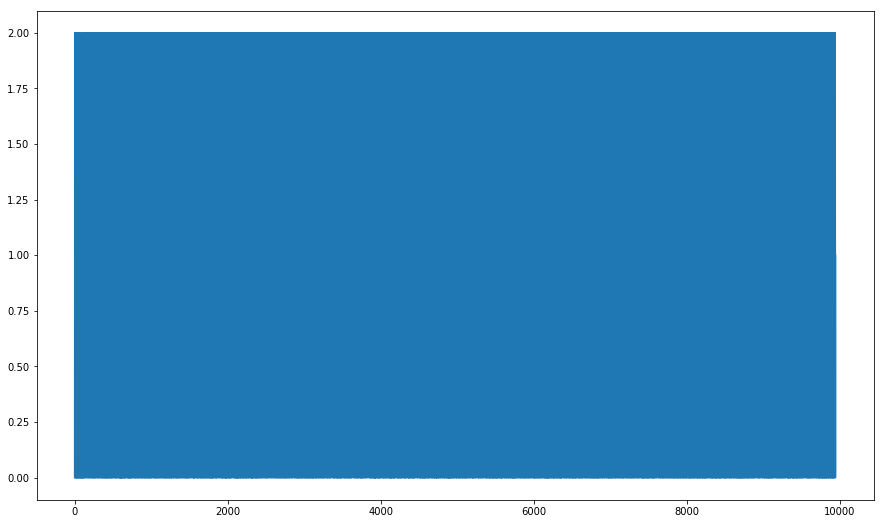

In [26]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

In [40]:
'''learning rate 0.01
batch size 64
epoch 100
-> 78%'''
'''learning rate 0.01
batch size 128
epoch 100
-> 77%'''
'''learning rate 0.0002
batch size 64
epoch 100
-> 85%'''
'''learning rate 0.0002
batch size 64
epoch 50
-> 85%'''
'''learning rate 0.0002
batch size 32
epoch 50
-> 84.6%'''

SyntaxError: invalid syntax (<ipython-input-40-a46e5f13d009>, line 1)